In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

### Environmental vars

In [2]:
P_THRESHOLD=0.5

In [3]:
DATADIR = os.getenv('DATADIR')

In [ ]:
print('algorithm running on data extracted from content store on {}'.format(DATADIR))

### get some data about taxons/content

In [4]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [5]:
# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [6]:
# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

### Load in data

In [ ]:
true_train = pd.read_csv(os.path.join(DATADIR, 'true_train_1255_2103_.csv.gz'), dtype=float, compression='gzip')
pred_train = pd.read_csv(os.path.join(DATADIR, 'train_results_1255_2103_.csv.gz'), dtype=float, compression='gzip')

In [10]:
true_dev = pd.read_csv(os.path.join(DATADIR, 'true_dev_1123_2703_.csv.gz'), dtype=float, compression='gzip')
prob_dev = pd.read_csv(os.path.join(DATADIR, 'dev_results_1123_2703_.csv.gz'), dtype=float, compression='gzip')

In [ ]:
train = np.load(os.path.join(DATADIR, 'train_arrays.npz'))

In [11]:
dev = np.load(os.path.join(DATADIR, 'dev_arrays.npz'))

In [ ]:
labelled_level2.loc[labelled_level2['content_id'].isin(train['content_id'])]

### Evaluate model

#### Training metrics

In [ ]:
y_pred = pred_train.copy()

In [ ]:
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [ ]:
print('micro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='weighted', sample_weight=None)))

In [ ]:
eval_metrics = precision_recall_fscore_support(true_train, y_pred, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

In [ ]:
train_metrics = eval_metrics_df.transpose()
train_metrics.columns = ['precision', 'recall', 'f1', 'support']
train_metrics['level2code'] = train_metrics.index +1
train_metrics['level2label'] = train_metrics['level2code'].map(labels_index)

In [ ]:
train_metrics.head()

In [ ]:
train_metrics.sort_values('support', ascending=False).plot(x='level2label', y='support', kind = 'bar', figsize=(35,10), legend=False)

#### Development set metrics

In [12]:
pred_dev = prob_dev.copy()

In [13]:
pred_dev[pred_dev>=P_THRESHOLD] = 1
pred_dev[pred_dev<P_THRESHOLD] = 0

In [14]:
print('micro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='weighted', sample_weight=None)))

micro: (0.86086904261073383, 0.80485475080069679, 0.83192008363340697, None)
macro: (0.76155486712440679, 0.79048635688826763, 0.76875357340137096, None)
weightedmacro: (0.8613058273851496, 0.80485475080069679, 0.82872027510771362, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
eval_metrics = precision_recall_fscore_support(true_dev, pred_dev, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
dev_metrics = eval_metrics_df.transpose()
dev_metrics.columns = ['precision', 'recall', 'f1', 'support']
dev_metrics['taxon2code'] = dev_metrics.index +1
dev_metrics['taxon2label'] = dev_metrics['taxon2code'].map(labels_index)

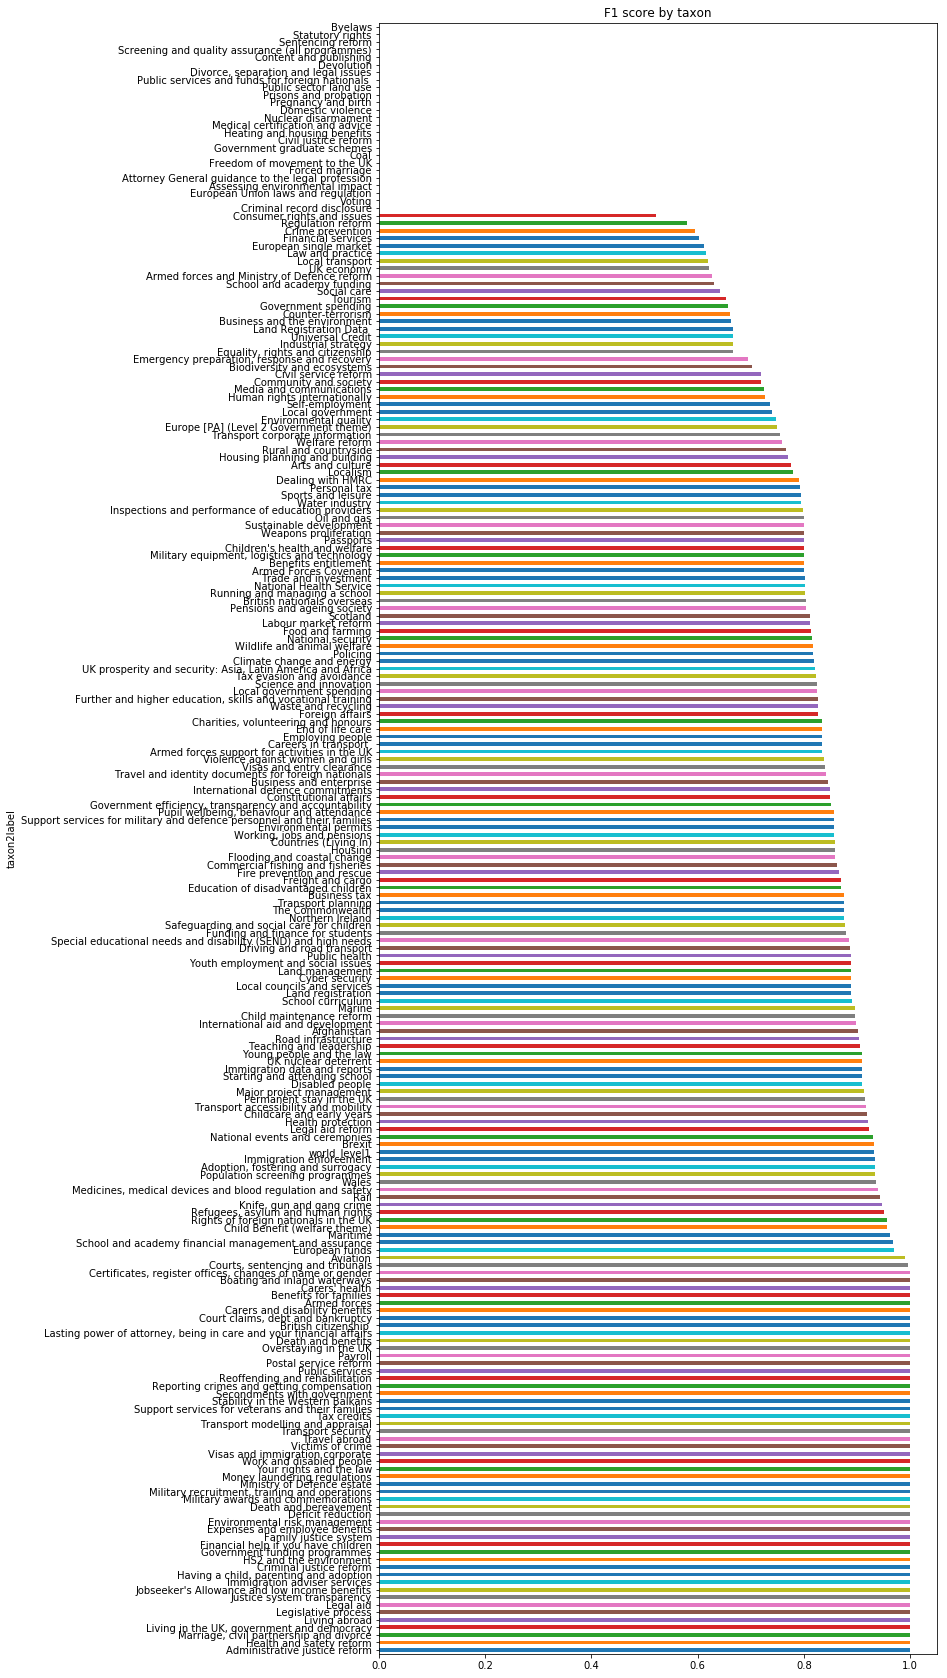

In [17]:
dev_metrics.sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'barh', figsize=(10,30), legend=False, title='F1 score by taxon')

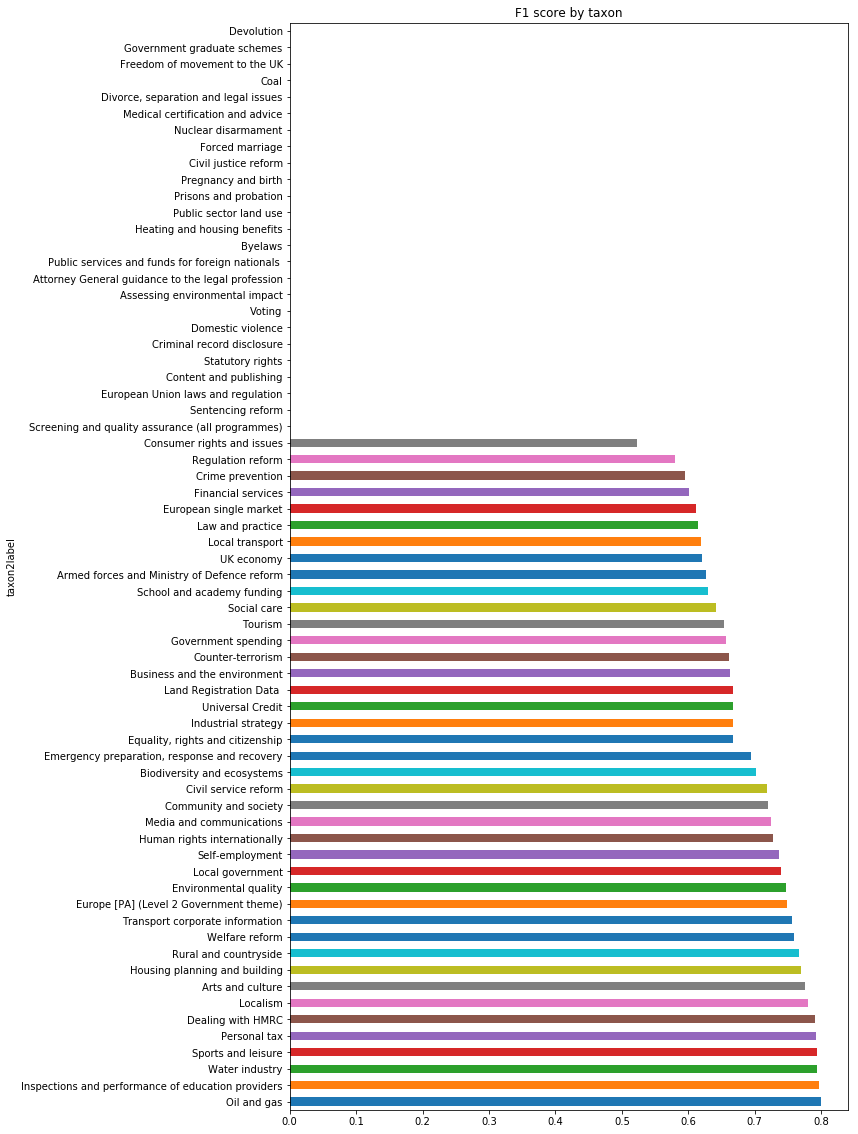

In [18]:
dev_metrics[dev_metrics['f1']<0.8].sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'barh', figsize=(10,20), legend=False, title='F1 score by taxon')

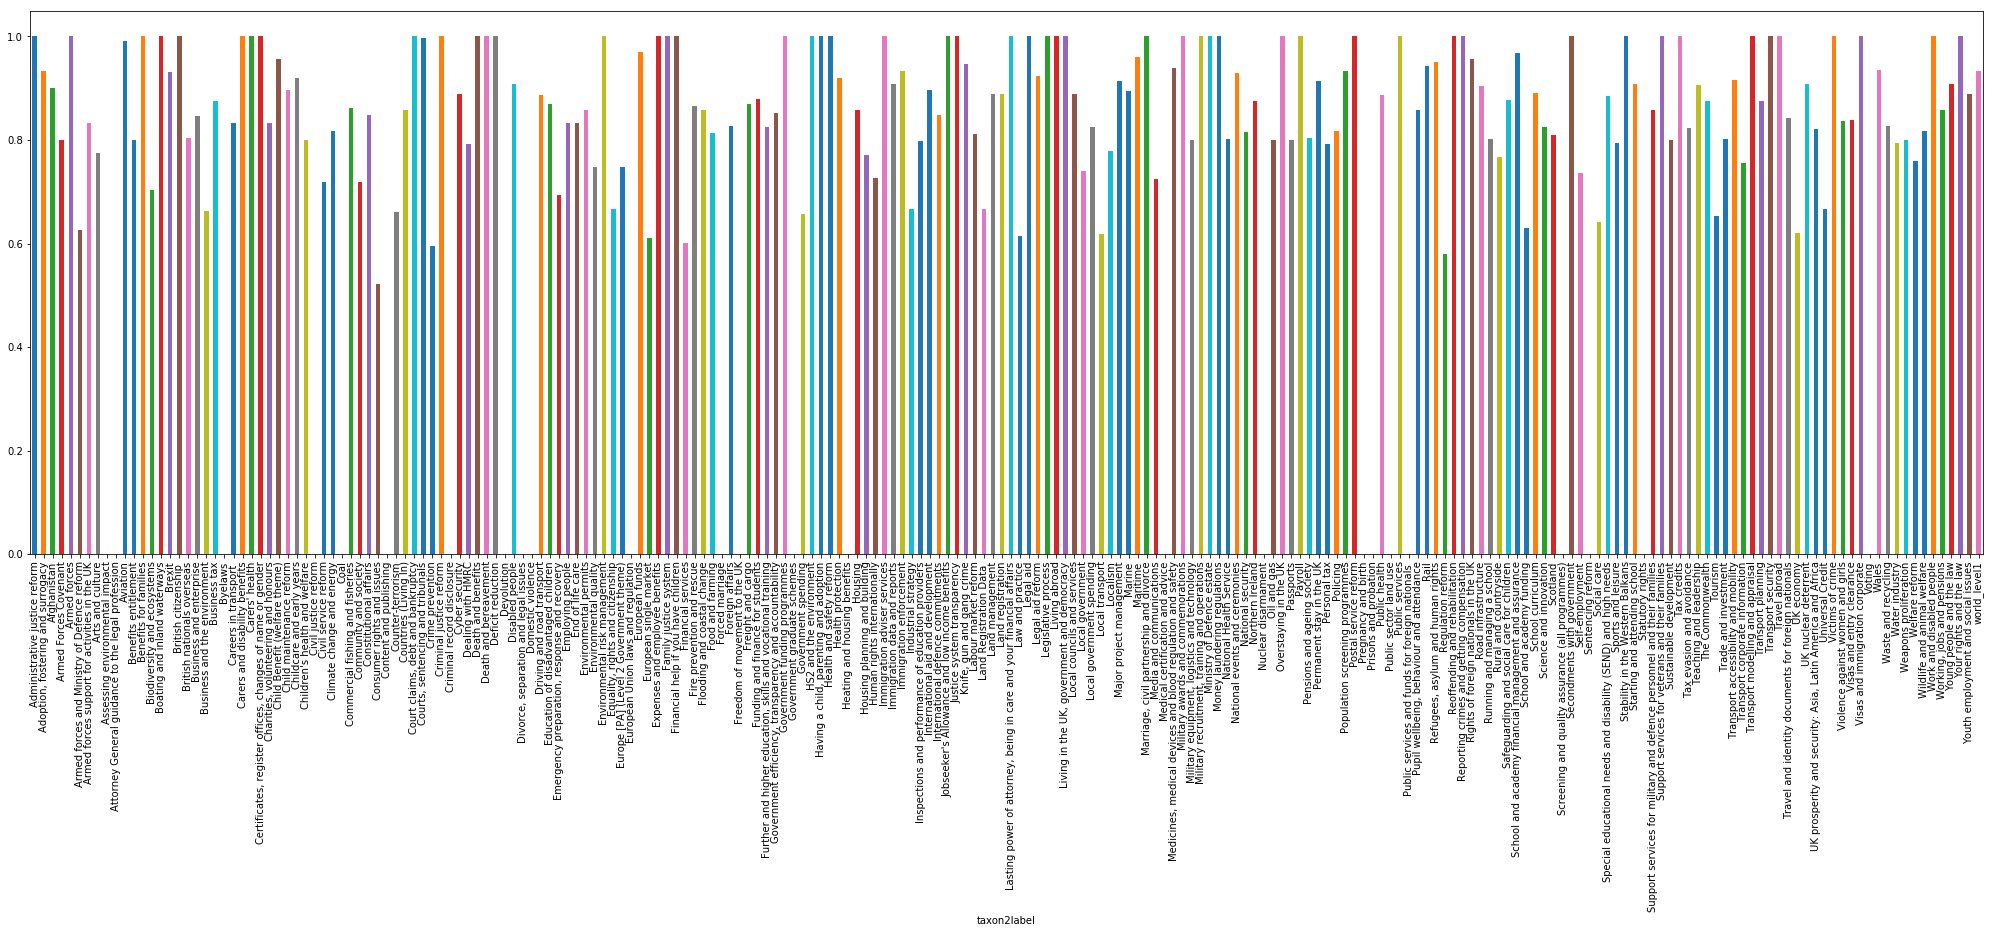

In [19]:
dev_metrics.sort_values('taxon2label', ascending=True).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35,10), legend=False)

In [20]:
dev_metrics[dev_metrics['f1']==0].shape[0]

25

In [21]:
dev_metrics[dev_metrics['f1']==1].shape[0]

51

In [22]:
dev_metrics[dev_metrics['f1']==1]

,precision,recall,f1,support,taxon2code,taxon2label
0,1.0,1.0,1.0,1.0,1,Administrative justice reform
4,1.0,1.0,1.0,56.0,5,Armed forces
12,1.0,1.0,1.0,2.0,13,Benefits for families
14,1.0,1.0,1.0,1.0,15,Boating and inland waterways
16,1.0,1.0,1.0,1.0,17,British citizenship
23,1.0,1.0,1.0,4.0,24,Carers and disability benefits
24,1.0,1.0,1.0,1.0,25,Carers' health
25,1.0,1.0,1.0,1.0,26,"Certificates, register offices, changes of nam..."
42,1.0,1.0,1.0,6.0,43,"Court claims, debt and bankruptcy"
45,1.0,1.0,1.0,6.0,46,Criminal justice reform


In [23]:
dev_metrics.to_csv(os.path.join(DATADIR, "dev_metrics.csv.gz"), compression='gzip',index=False)

In [27]:
high = dev_metrics[dev_metrics['f1']>0.9]

In [28]:
morethan80 = dev_metrics[dev_metrics['f1']>0.8]

In [29]:
dev_metrics[dev_metrics['f1']<0.6].shape[0]

25

In [30]:
dev_metrics[dev_metrics['f1']<0.8].shape

(78, 6)

In [31]:
dev_metrics[dev_metrics['f1']==0].shape

(22, 6)

In [32]:
dev_metrics[dev_metrics['taxon2label']=='UK economy']

,precision,recall,f1,support,taxon2code,taxon2label
196,0.624365,0.67806,0.650106,907.0,197,UK economy


## support and performance

The support is the number of occurrences of each class in y_true

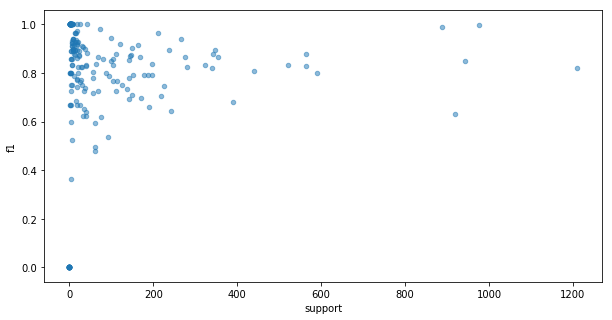

In [40]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))


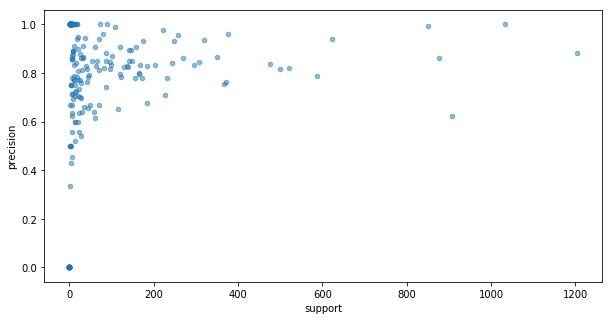

In [28]:
dev_metrics.plot.scatter(x='support', y='precision', marker='o', alpha=.5, figsize=(10, 5))


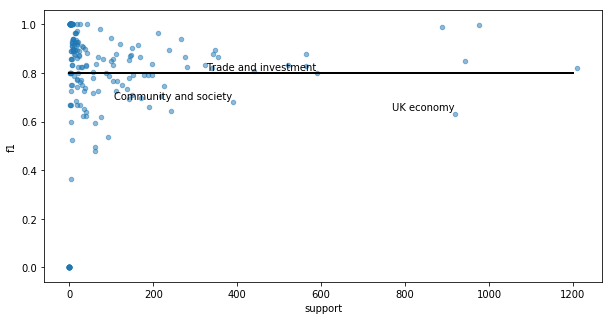

In [41]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))
plt.plot([0, 1200],[0.8, 0.8],  'k-', lw=2)

for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if (x>300 and y<0.8):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
        
plt.show()

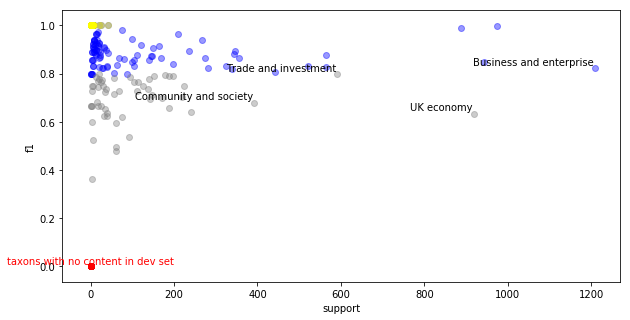

In [43]:
# normal values
plt.figure(figsize=(10, 5))
plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
         verticalalignment='bottom')
plt.xlabel('support')
plt.ylabel('f1')
plt.scatter(dev_metrics['support'][dev_metrics['f1']>=0.8], 
            dev_metrics['f1'][dev_metrics['f1']>=0.8], 
            c = 'b', 
            alpha=.4)
# less than 0.8
plt.scatter(dev_metrics['support'][dev_metrics['f1']<0.8], 
            dev_metrics['f1'][dev_metrics['f1']<0.8], 
            c = 'grey', 
            alpha=.4)

plt.scatter(dev_metrics['support'][dev_metrics['f1']==0], 
            dev_metrics['f1'][dev_metrics['f1']==0], 
            c = 'red', 
            alpha=.4)
plt.scatter(dev_metrics['support'][dev_metrics['f1']==1], 
            dev_metrics['f1'][dev_metrics['f1']==1], 
            c = 'yellow', 
            alpha=.4)


for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if ((x>300 and y<0.8) or (x>1000)):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')


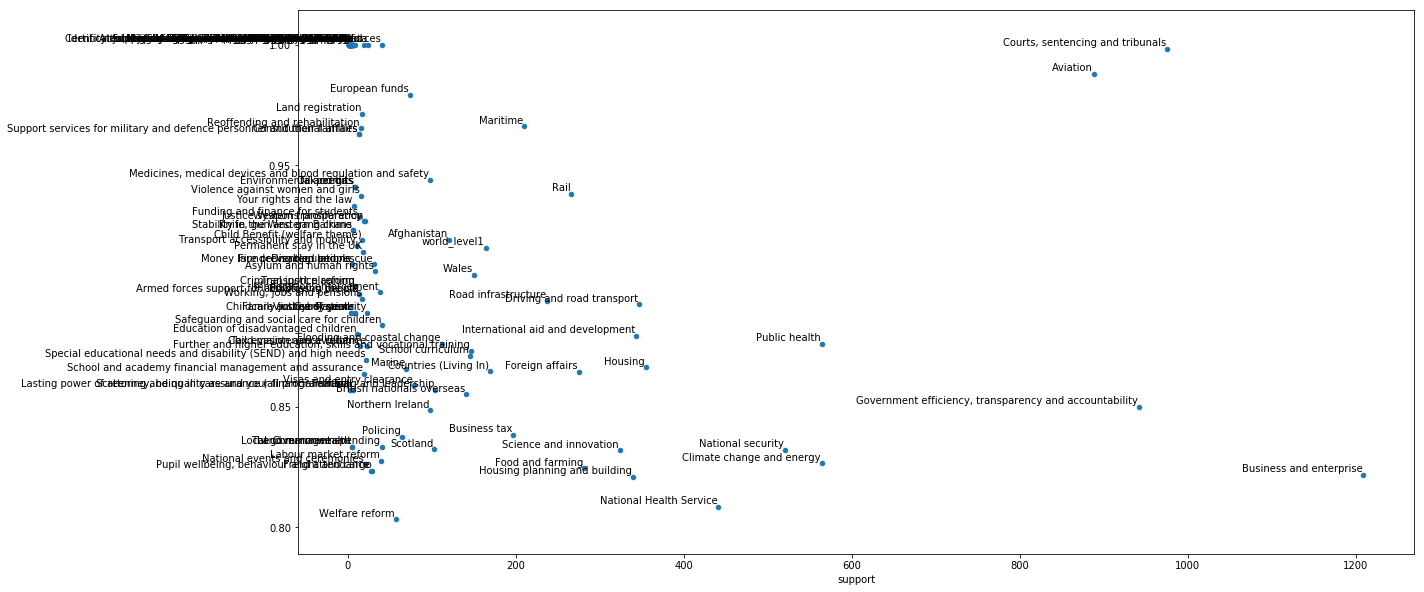

In [44]:
morethan80.plot.scatter(x='support', y='f1', figsize=(20, 10))

for label, x, y in zip(morethan80['taxon2label'], morethan80['support'], morethan80['f1']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

### look at content predicted in taxons with f1=1

In [45]:
prob_dev.head()

,1,2,3,4,5,6,7,8,9,10,...,208,209,210,211,212,213,214,215,216,217
0,1.430879e-09,3.309768e-08,4.247052e-13,8.958880e-13,1.298320e-10,3.362877e-12,1.229251e-12,6.832324e-08,2.213320e-10,1.292042e-11,...,3.082676e-07,9.380426e-14,1.452233e-07,2.354326e-11,4.151500e-11,5.813562e-10,7.937041e-12,2.377054e-11,4.236804e-12,1.841895e-09
1,3.113968e-13,3.778706e-12,7.884918e-17,9.256854e-16,8.363572e-16,1.481720e-11,1.824040e-17,3.851755e-17,3.049423e-11,7.666534e-16,...,2.005971e-09,1.607120e-11,9.737212e-12,1.821037e-13,2.061460e-13,1.941882e-16,3.676411e-15,8.298838e-15,1.369991e-15,4.240184e-15
2,2.116866e-08,2.228589e-08,1.819893e-08,1.151717e-08,5.583671e-08,2.767320e-06,3.104766e-07,5.035183e-05,4.062409e-07,4.108228e-05,...,5.028557e-07,4.117422e-09,2.279215e-08,6.398191e-06,1.281500e-08,8.433078e-08,3.270990e-08,4.669498e-07,5.013872e-09,1.333951e-11
3,3.340944e-22,1.473327e-24,0.000000e+00,0.000000e+00,2.092249e-29,0.000000e+00,0.000000e+00,1.243686e-35,4.582615e-23,9.274240e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.962431e-28,3.588763e-18,0.000000e+00,1.783602e-14,6.085796e-38,5.465818e-36
4,3.831374e-15,4.467982e-15,2.698618e-09,1.396589e-07,5.983008e-11,3.146719e-01,5.949466e-09,1.307382e-10,5.920678e-13,4.522938e-17,...,1.468630e-13,3.077830e-07,1.313327e-16,4.691339e-07,2.959625e-10,9.617959e-11,1.781978e-16,4.001303e-14,3.831268e-13,4.190362e-11


In [46]:
dev_metrics[dev_metrics['f1']==1].head()

,precision,recall,f1,support,taxon2code,taxon2label
0,1.0,1.0,1.0,1.0,1,Administrative justice reform
1,1.0,1.0,1.0,5.0,2,"Adoption, fostering and surrogacy"
4,1.0,1.0,1.0,41.0,5,Armed forces
10,1.0,1.0,1.0,2.0,11,Attorney General guidance to the legal profession
13,1.0,1.0,1.0,2.0,14,Benefits for families


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))